# Import libraries and Dataset

In [1]:
from pyspark import SparkContext
import numpy as np
import pandas as pd
import pickle
import os
import shutil

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

import datasets
import eval_methods
import sklearn_models
import pyspark_models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

seed = 0

try:
    sc = SparkContext().getOrCreate()
except:
    pass

2022-11-07 16:41:15.883305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-07 16:41:15.883339: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We have built two functions saved in dataset.py file which preprocesses the data for both sklearn and pyspark and loads it into train and test data.

In [2]:
x_train, x_test, y_train, y_test = datasets.get_sklearn_titanic()
train, test = datasets.get_pyspark_titanic(sc)

# Define Baseline Models

After importing the libraries and the preprocessed titanic dataset we can import both the sklearn and pyspark models and initialize them with only the required hyperparameters, and leave the rest as default to get baseline accuracy. But we have set the random_state or seed value to ensure reproducibility.

In [3]:
sklearn_classifiers = [
    sklearn_models.LinearSVC(random_state=seed),
    sklearn_models.LogisticRegression(random_state=seed),
    sklearn_models.DecisionTreeClassifier(random_state=seed),
    sklearn_models.RandomForestClassifier(random_state=seed),
    sklearn_models.GaussianNB(),
    sklearn_models.GradientBoostingClassifier(random_state=seed),
    sklearn_models.MLPClassifier(random_state=seed),
    sklearn_models.OneVsRestClassifier(sklearn_models.LinearSVC())]
pyspark_classifiers = [
    pyspark_models.LinearSVC(labelCol="label"),
    pyspark_models.LogisticRegression(labelCol="label"),
    pyspark_models.DecisionTreeClassifier(labelCol="label", seed=seed),
    pyspark_models.RandomForestClassifier(labelCol='label', seed=seed),
    pyspark_models.NaiveBayes(labelCol='label', modelType="gaussian"),
    pyspark_models.GBTClassifier(labelCol='label', seed=seed),
    pyspark_models.MultilayerPerceptronClassifier(
        labelCol='label', seed=seed,
        layers=[
            len(test.toPandas()["features"][0]),
            100, ]),
    pyspark_models.OneVsRest(labelCol='label',
                             classifier=pyspark_models.LinearSVC())]

Now we can train the sklearn, pyspark and keras models and save the accuracy, confusion matrices, roc, precision and recall to visiualize later. We have also built a file called eval_methods.py, which visiualizes these metrices.

2022-11-07 16:41:26.295149: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-07 16:41:26.295172: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Haftamu-YOGA): /proc/driver/nvidia/version does not exist
2022-11-07 16:41:26.296219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


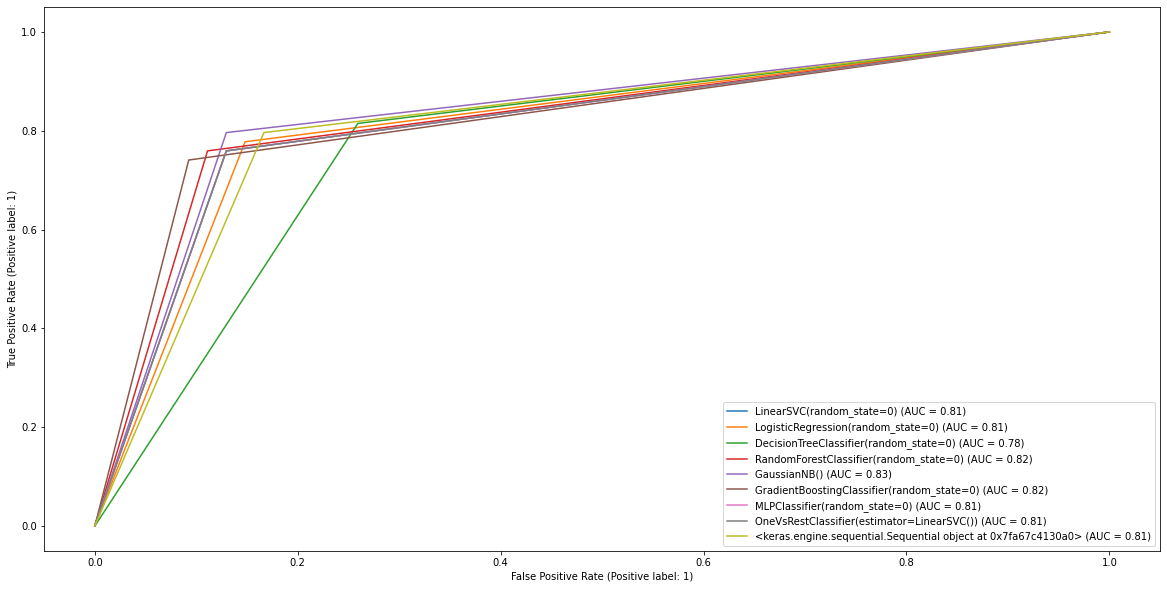

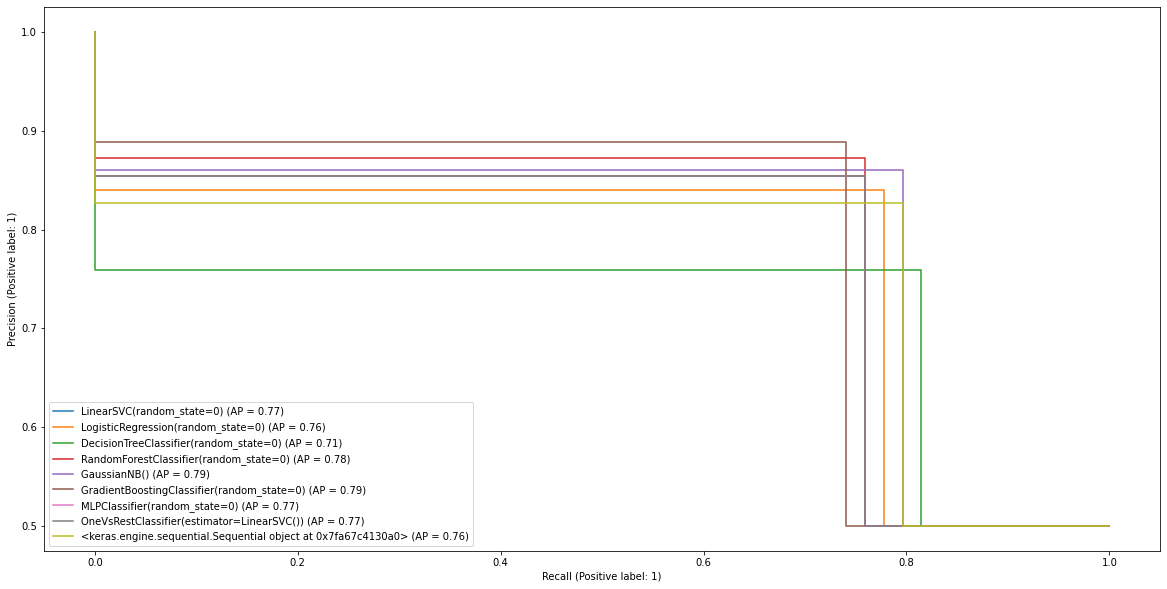

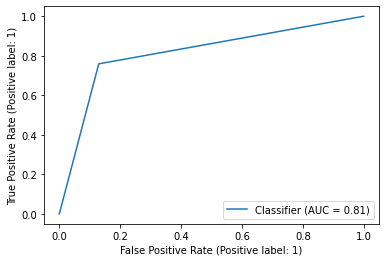

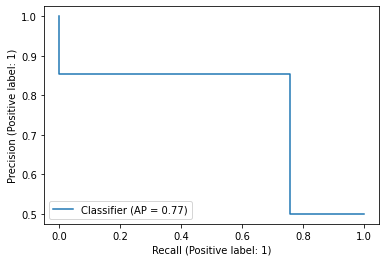

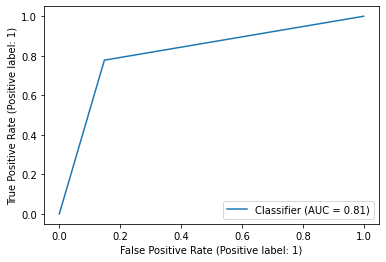

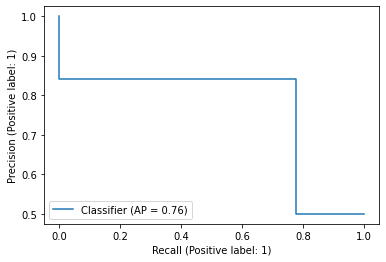

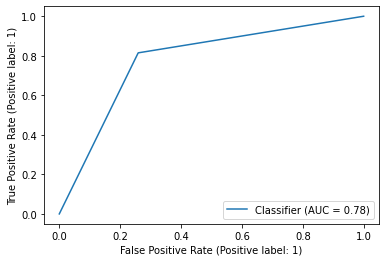

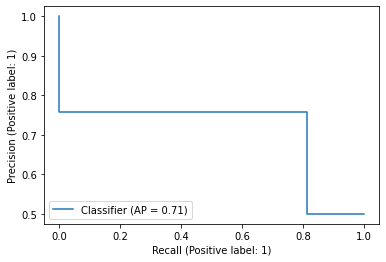

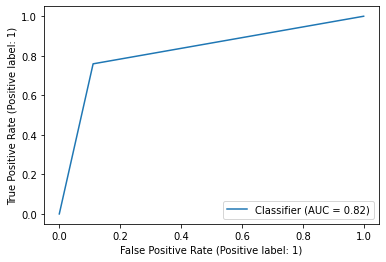

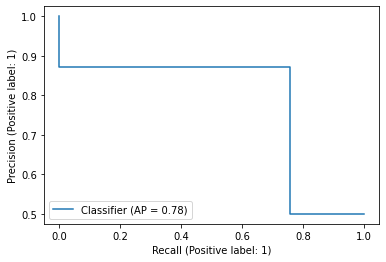

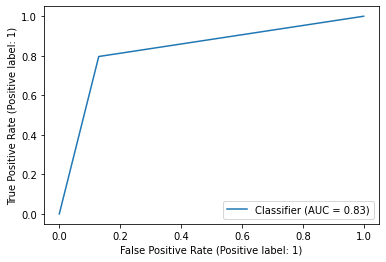

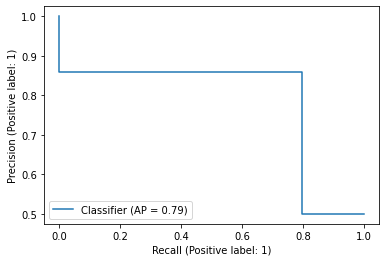

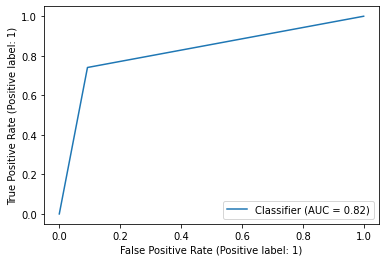

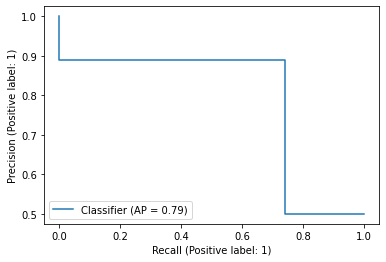

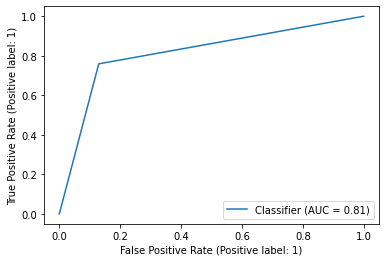

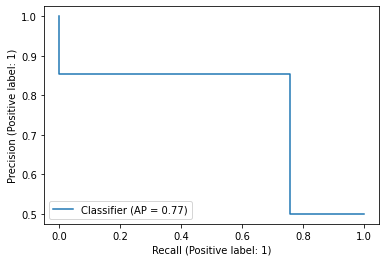

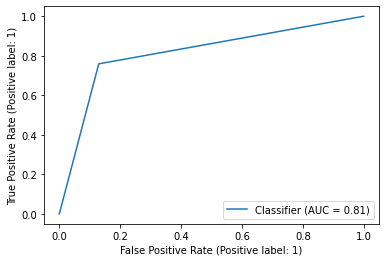

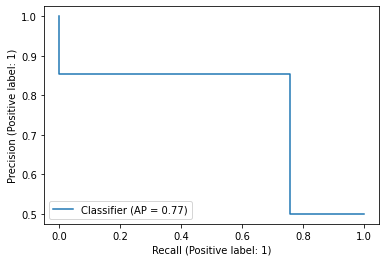

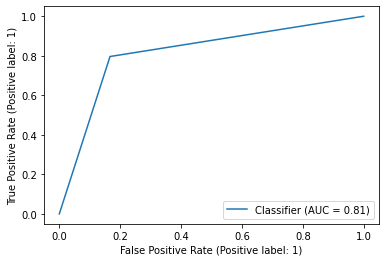

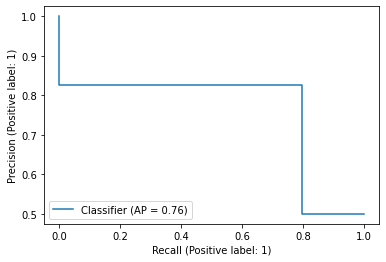

In [4]:
sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in sklearn_classifiers:
    clf.fit(x_train, y_train)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(
        clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)

clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(
    clf, y_test,
    np.round(clf.predict(x_test, verbose=0))[:, 0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)

22/11/07 16:41:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/07 16:41:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/11/07 16:42:06 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/07 16:42:06 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


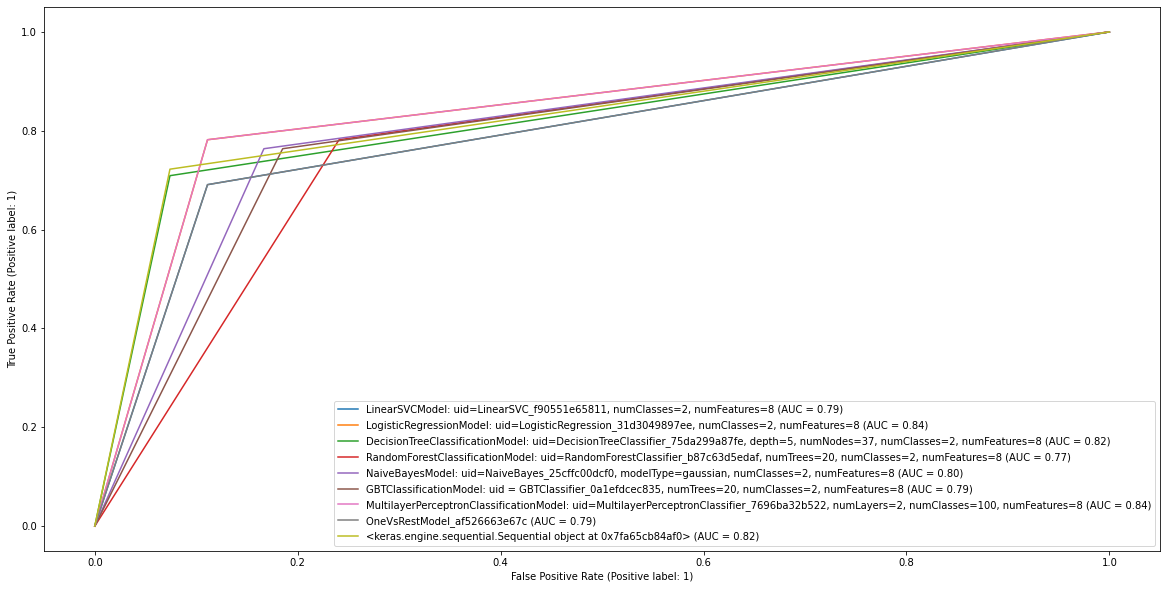

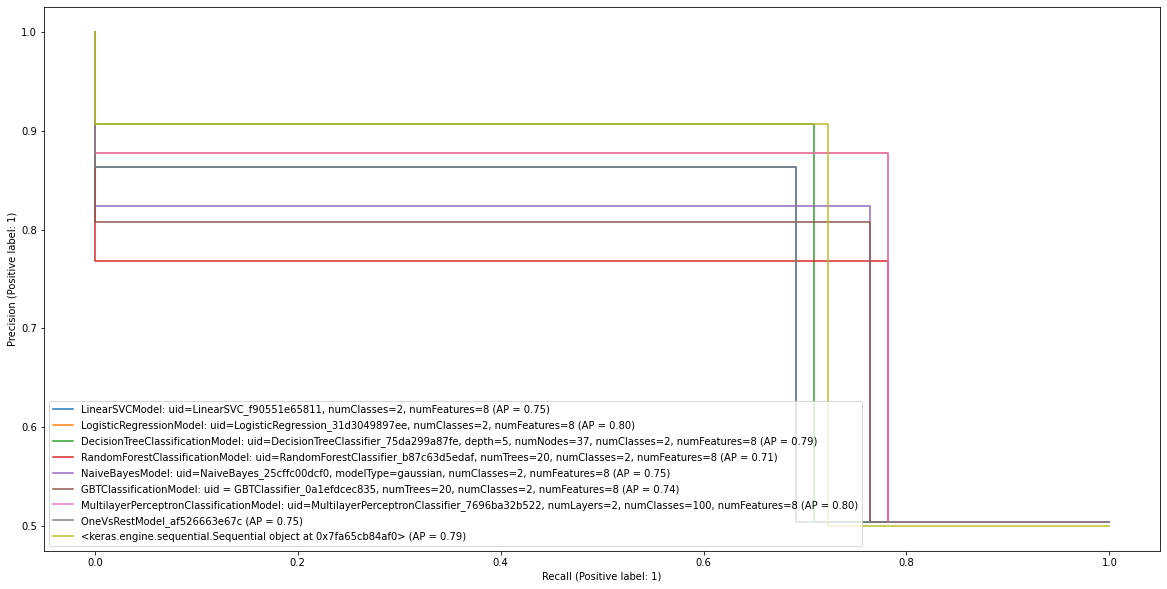

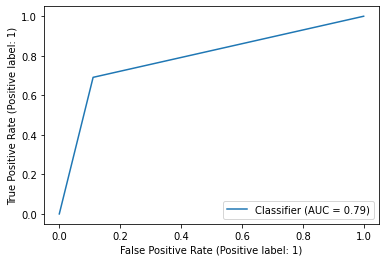

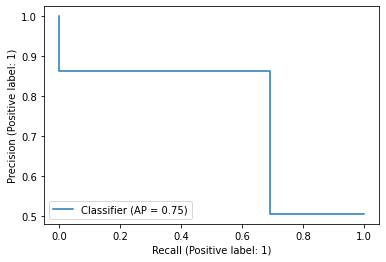

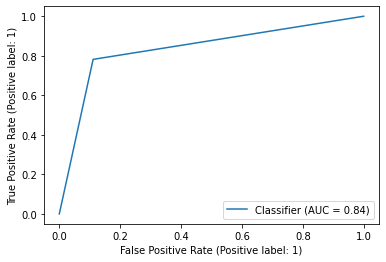

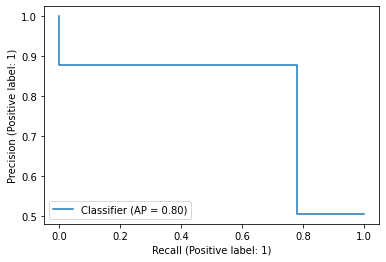

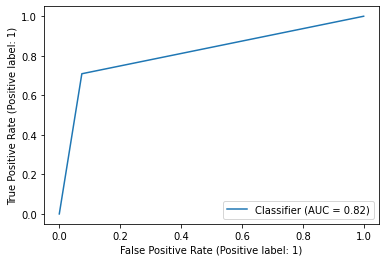

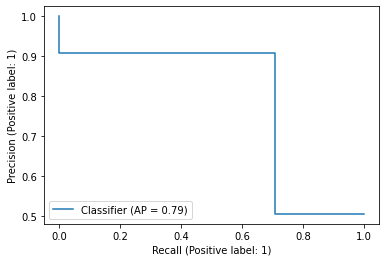

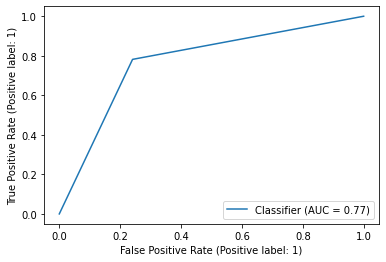

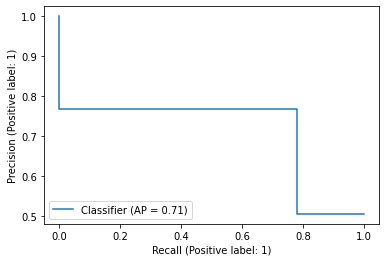

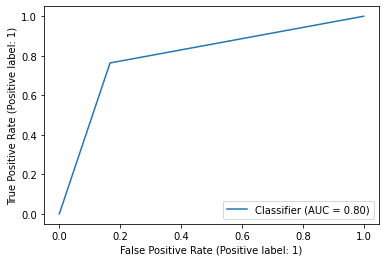

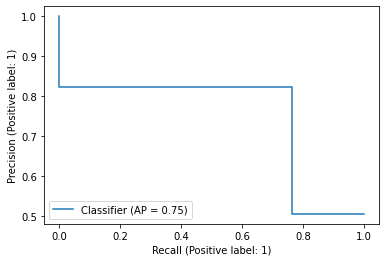

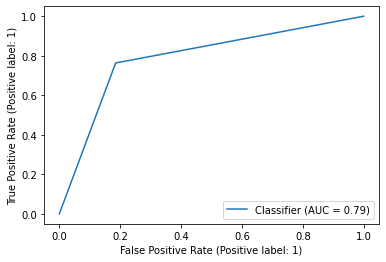

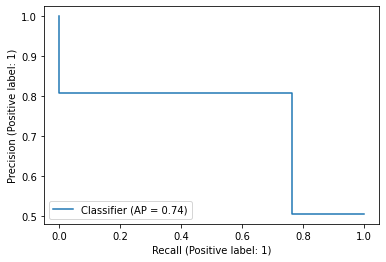

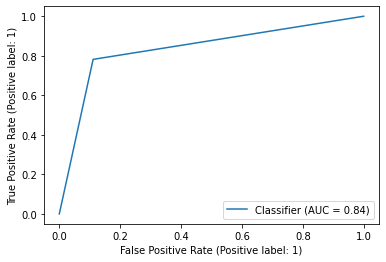

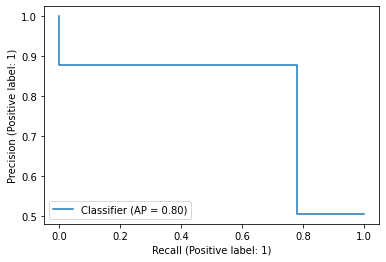

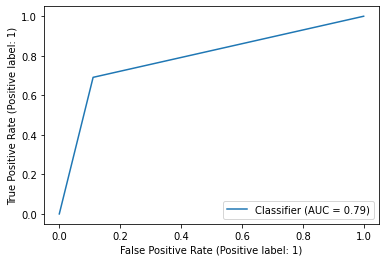

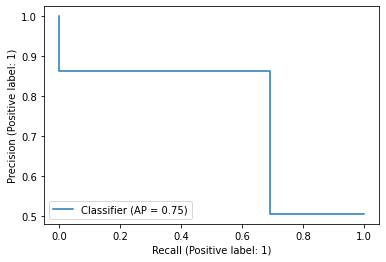

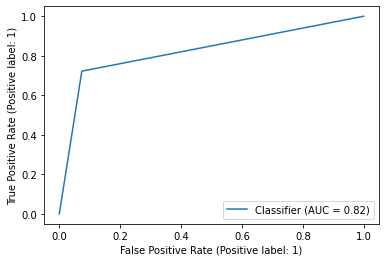

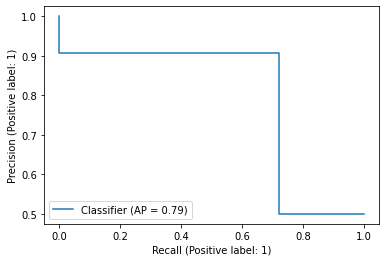

In [5]:
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in pyspark_classifiers:
    clf = clf.fit(train)
    real = np.array([
        1 if "1" in str(x) else 0
        for x in clf.transform(test).select("label").collect()])
    pred = np.array([
        1 if "1" in str(x) else 0
        for x in clf.transform(test).select("prediction").collect()])
    accuracy, confusion, roc, precision, recall = eval_methods.eval(
        clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)

clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(
    clf, y_test,
    np.round(clf.predict(x_test, verbose=0))[:, 0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

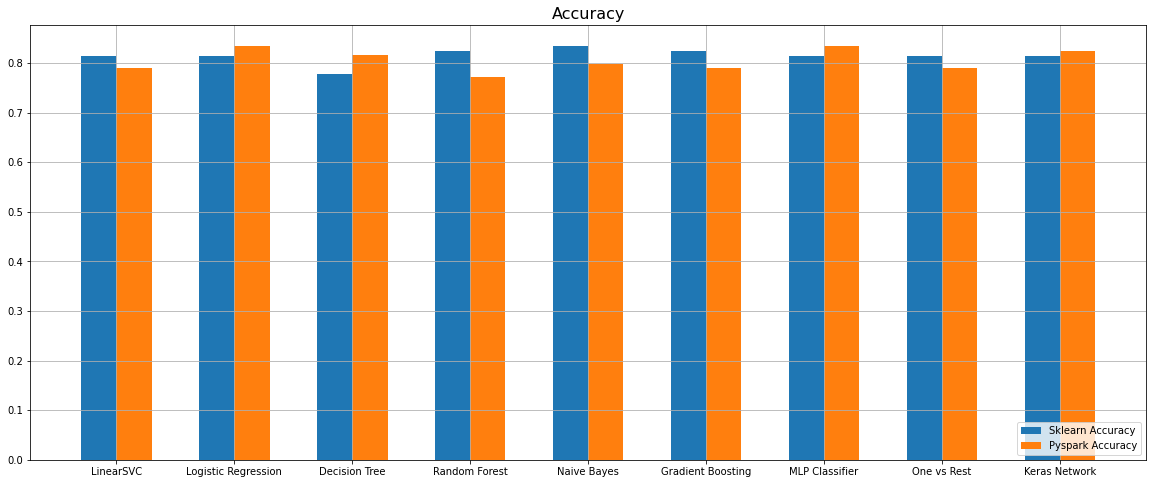

In [6]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

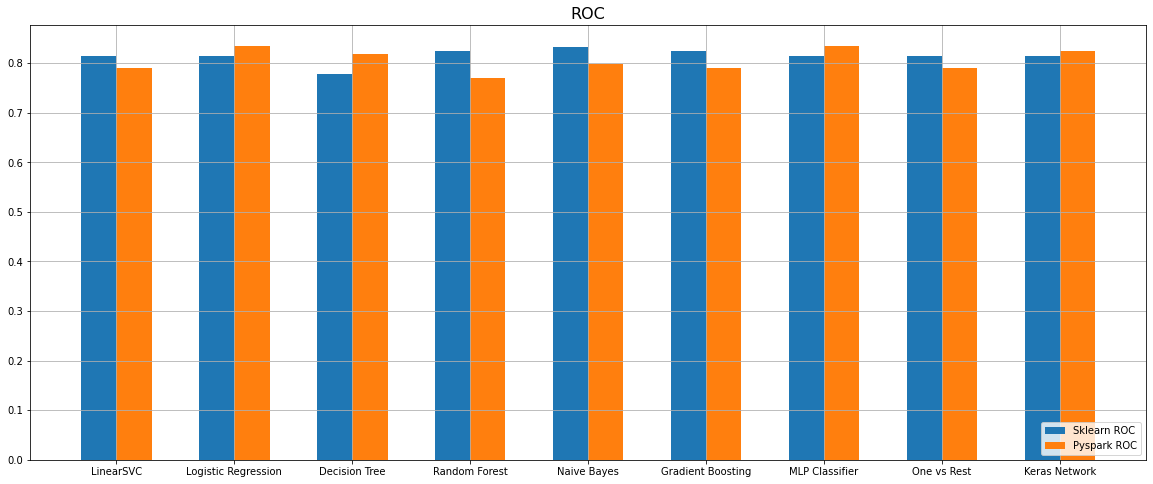

In [7]:
eval_methods.plot(sklearn_roc, pyspark_roc, "ROC")

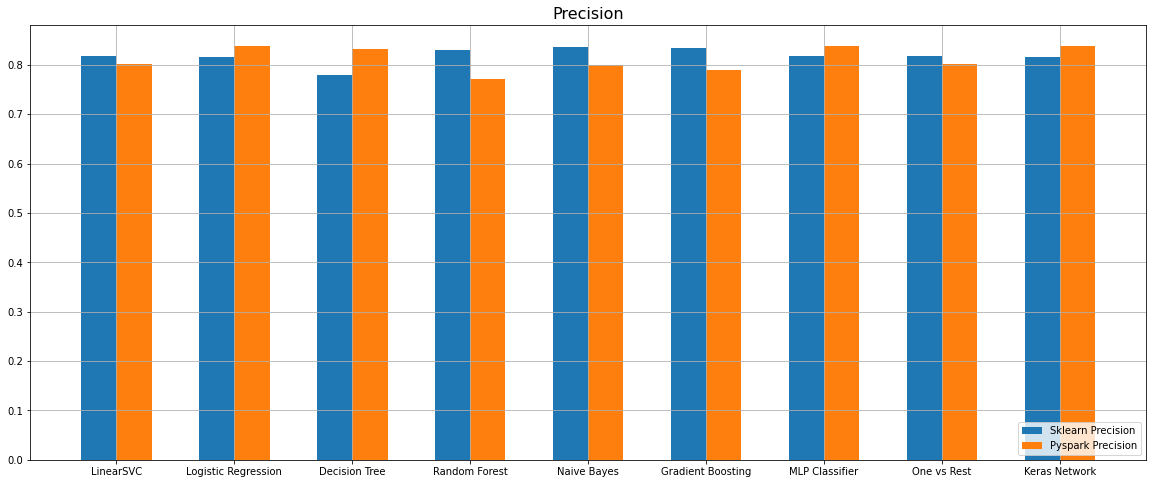

In [8]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

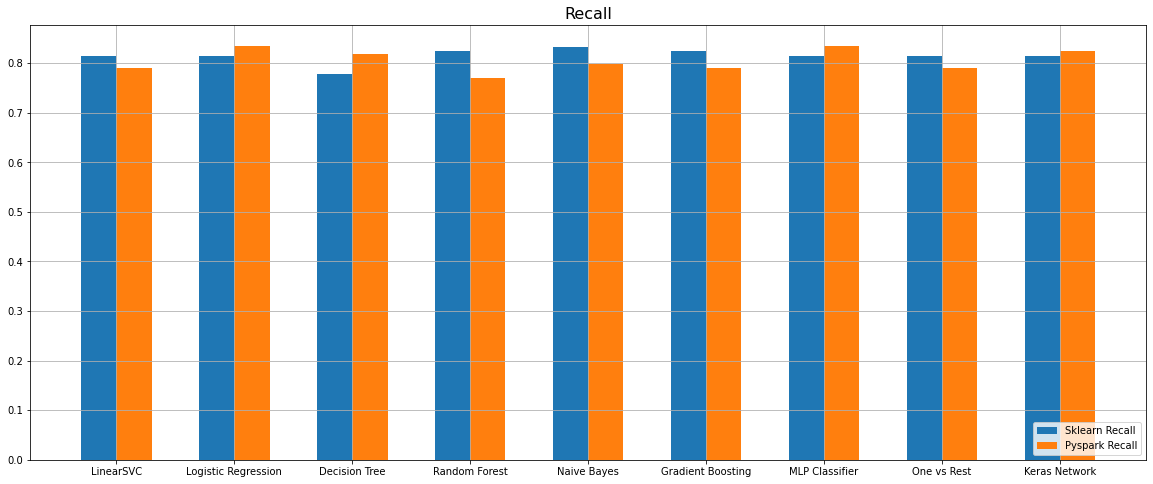

In [9]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

Now we can define some hyperparameters and their values for the gridsearch algorithm. Only those hyperparameters are selected which are common in both versions, that is the pyspark and sklearn models. But the gridseach is performed on sklearn and the same combination of hyperparameters is applied on pyspark models to keep the comparision fair.

In [10]:
grid = {
    "LinearSVC": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "LogisticRegression": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "DecisionTreeClassifier": {
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"]},
    "RandomForestClassifier": {
        "bootstrap": [True, False],
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"],
        "n_estimators": [5, 10, 50, 100]},
    "GaussianNB": {
        "var_smoothing": [1e-07, 1e-08, 1e-09, 1e-10]},
    "GradientBoostingClassifier": {
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": [2, 5, 10, 20],
        "learning_rate": [0.1, 0.01, 0.001, 0.0001]},
    "MLPClassifier": {
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "max_iter": [10, 50, 100, 500],
        "batch_size": [8, 32, 128, 512]},
    "OneVsRestClassifier": {
        "n_jobs": [1, 3, 5, 7, 10]}}

In [11]:
para = {
    "LinearSVC": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "LogisticRegression": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "DecisionTreeClassifier": {
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"]},
    "RandomForestClassifier": {
        "bootstrap": ["bootstrap"],
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"],
        "n_estimators": ["numTrees"]},
    "GaussianNB": {
        "var_smoothing": ["smoothing"]},
    "GradientBoostingClassifier": {
        "max_features": ["featureSubsetStrategy"],
        "max_depth": ["maxDepth"],
        "learning_rate": ["stepSize"]},
    "MLPClassifier": {
        "tol": ["tol"],
        "max_iter": ["maxIter"],
        "batch_size": ["blockSize"]},
    "OneVsRestClassifier": {
        "n_jobs": ["parallelism"]}}

Now we apply gridsearch to sklearn algorithms, with 5-fold crossvalidation. And then the models are trained using the best cobmbination of hyperparameters, and we save the performance metrics and the models are saved as .sav file using pickle for latter use.

LinearSVC {'C': 0.0001, 'fit_intercept': True, 'max_iter': 10, 'tol': 0.01}
LogisticRegression {'C': 0.01, 'fit_intercept': True, 'max_iter': 10, 'tol': 0.01}
DecisionTreeClassifier {'criterion': 'gini', 'max_depth': 2}
RandomForestClassifier {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
GaussianNB {'var_smoothing': 1e-07}
GradientBoostingClassifier {'learning_rate': 0.01, 'max_depth': 2, 'max_features': 'auto'}
MLPClassifier {'batch_size': 128, 'max_iter': 500, 'tol': 0.0001}
OneVsRestClassifier {'n_jobs': 1}


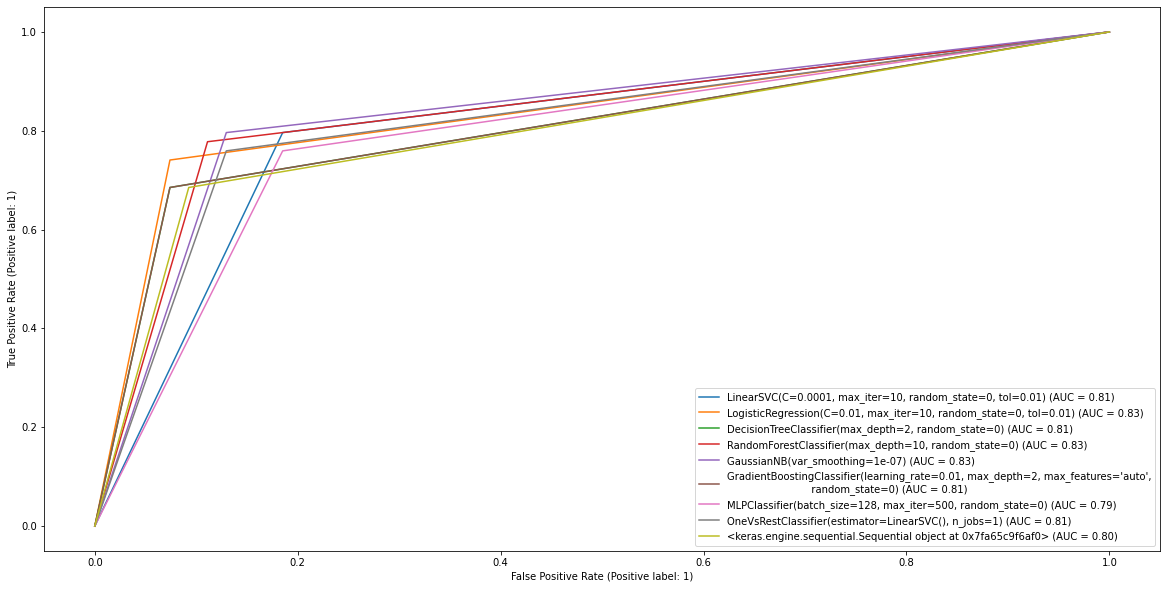

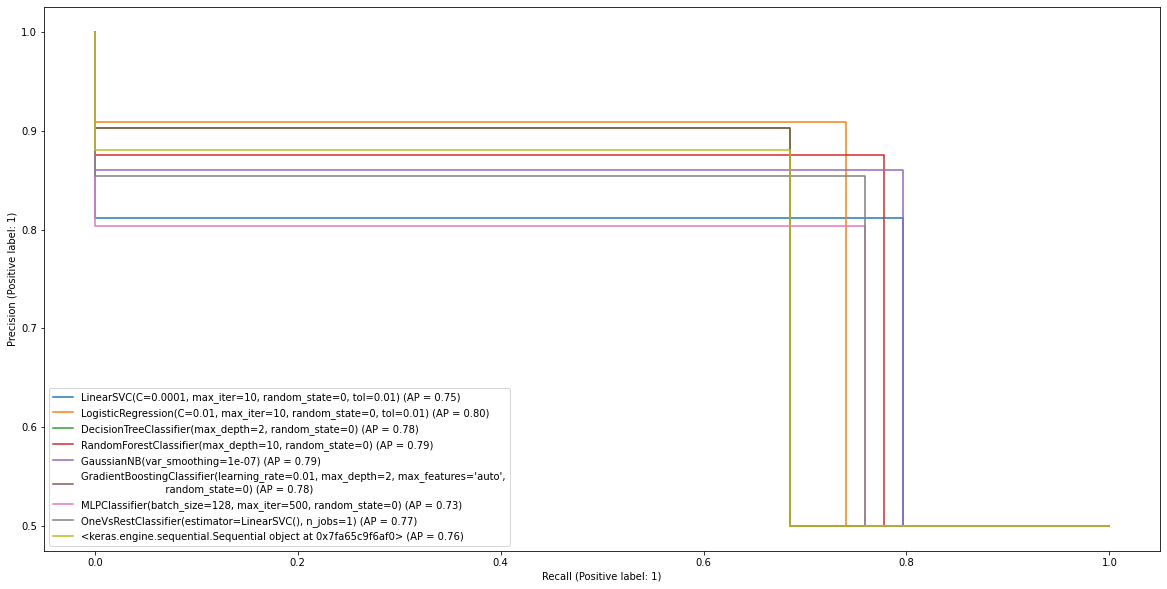

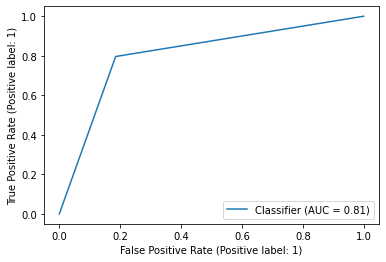

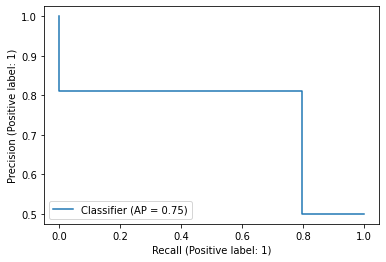

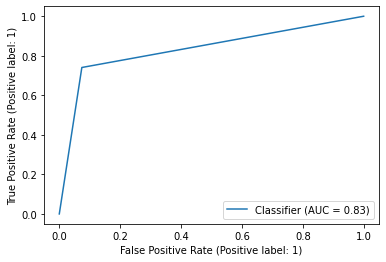

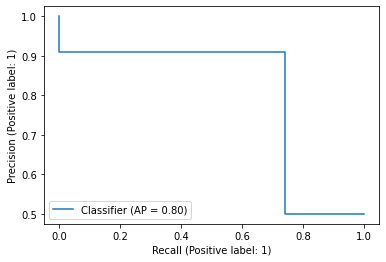

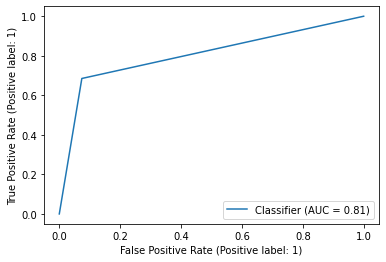

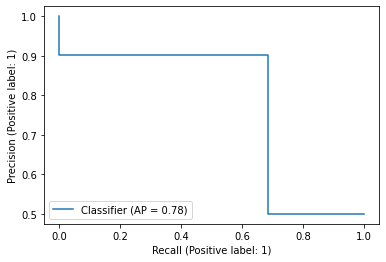

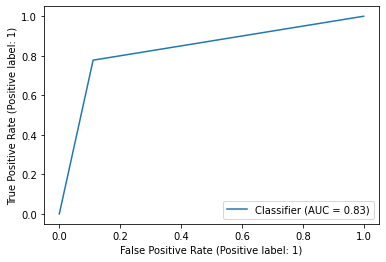

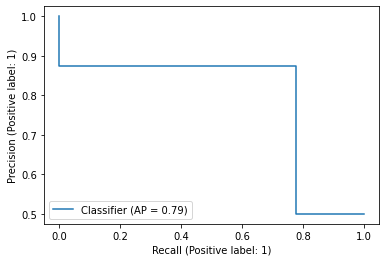

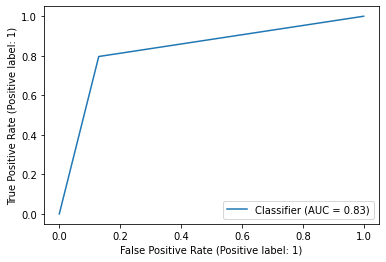

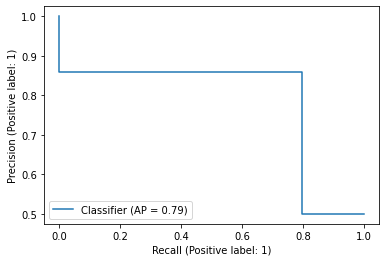

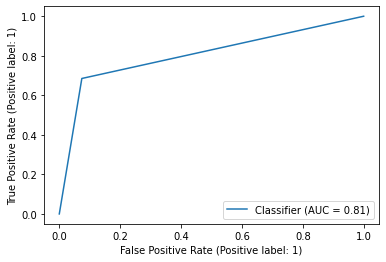

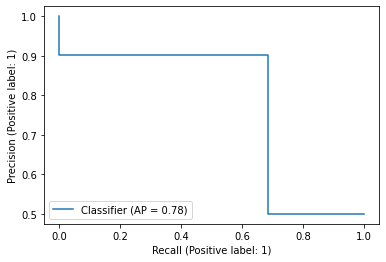

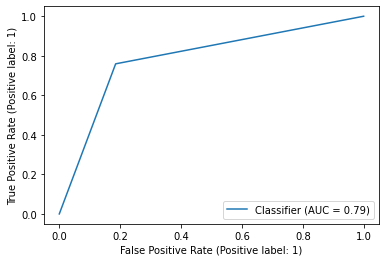

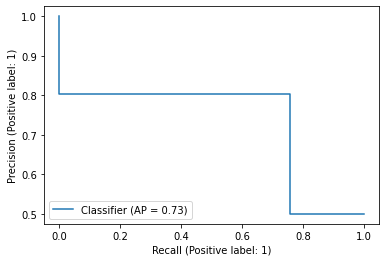

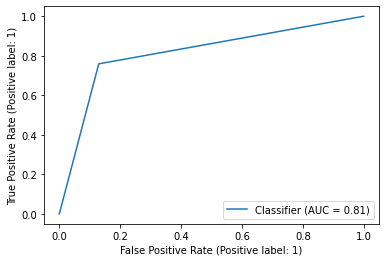

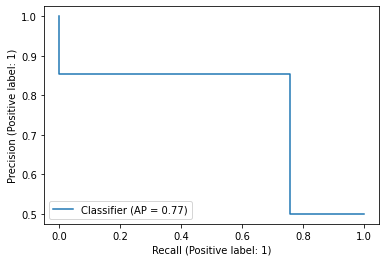

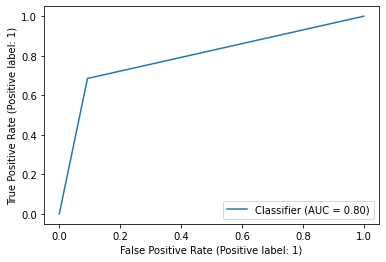

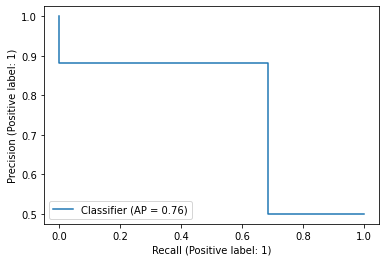

In [12]:
sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []

_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in sklearn_classifiers:
    rf_cv = GridSearchCV(
        estimator=clf, param_grid=grid[str(clf)[:str(clf).find("(")]], cv=5)
    rf_cv.fit(x_train, y_train)
    clf = clf.set_params(**rf_cv.best_params_)
    clf.fit(x_train, y_train)
    if not os.path.exists("./models/titanic/sklearn/"):
        os.makedirs("./models/titanic/sklearn/")
    pickle.dump(clf, open("./models/titanic/sklearn/" +
                str(clf)[:str(clf).find("(")]+".sav", 'wb'))
    for i, v in rf_cv.best_params_.items():
        para[str(clf)[:str(clf).find("(")]][i].append(v)
    print(str(clf)[:str(clf).find("(")], rf_cv.best_params_)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(
        clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)

clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=5)
accuracy, confusion, roc, precision, recall = eval_methods.eval(
    clf, y_test, np.round(clf.predict(x_test, verbose=0))[:, 0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)

Now we apply the same hyperparameters to pyspark and train the models, then save the performance matrices, visialize them and save the models.

In [13]:
grid = {}
for i in para.keys():
    if i == "GaussianNB":
        grid["NaiveBayes"] = {}
        for j in para[i].values():
            grid["NaiveBayes"][j[0]] = j[1]
    elif i == "GradientBoostingClassifier":
        grid["GBTClassifier"] = {}
        for j in para[i].values():
            grid["GBTClassifier"][j[0]] = j[1]
    elif i == "MLPClassifier":
        grid["MultilayerPerceptronClassifier"] = {}
        for j in para[i].values():
            grid["MultilayerPerceptronClassifier"][j[0]] = j[1]
    elif i == "OneVsRestClassifier":
        grid["OneVsRest"] = {}
        for j in para[i].values():
            grid["OneVsRest"][j[0]] = j[1]
    else:
        grid[i] = {}
        for j in para[i].values():
            grid[i][j[0]] = j[1]

22/11/07 16:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1122.4 KiB
22/11/07 16:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1350.1 KiB
22/11/07 16:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1540.4 KiB
22/11/07 16:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1137.7 KiB


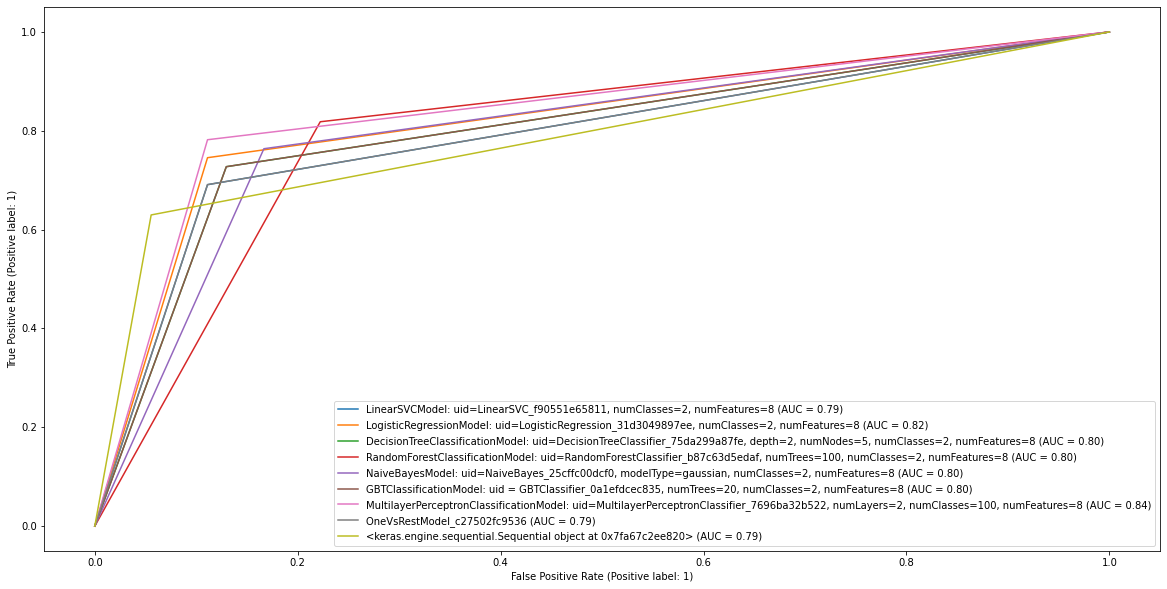

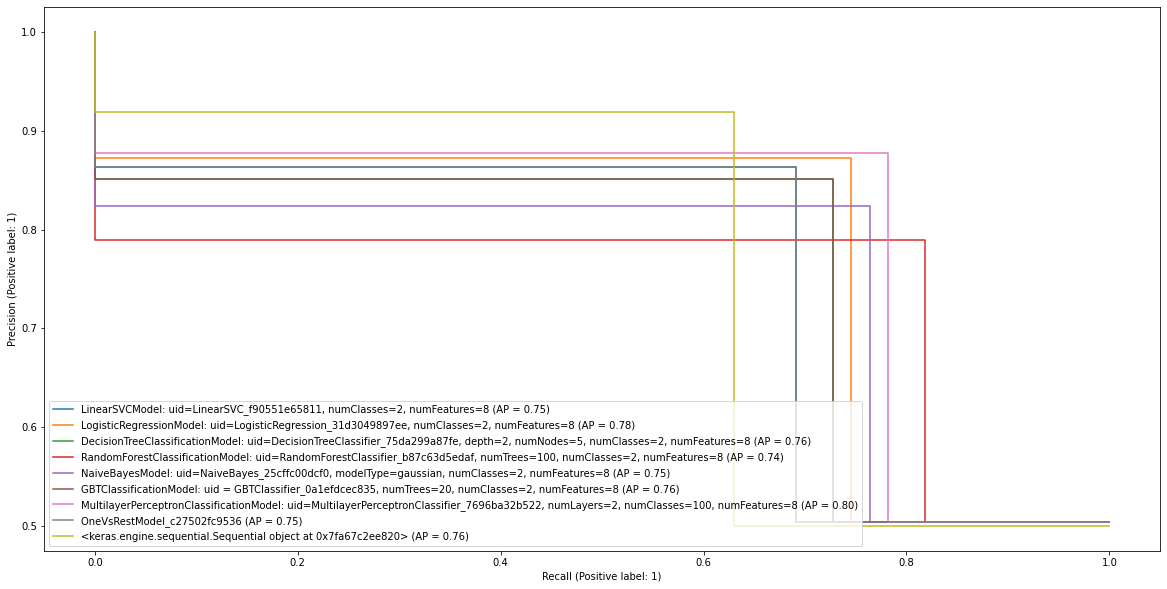

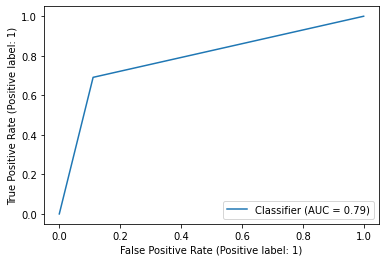

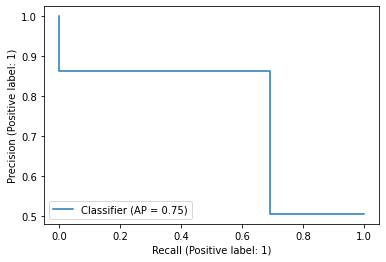

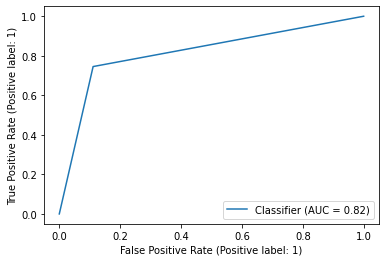

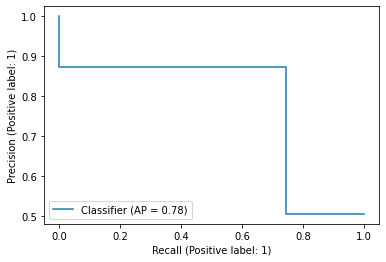

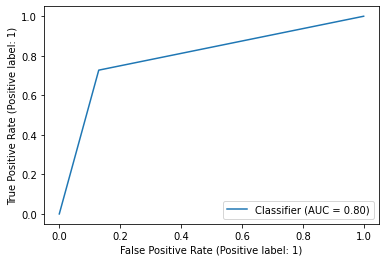

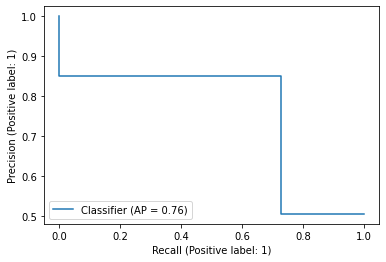

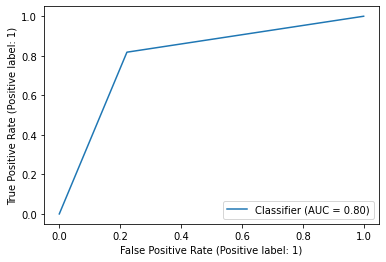

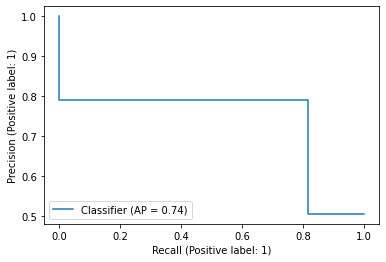

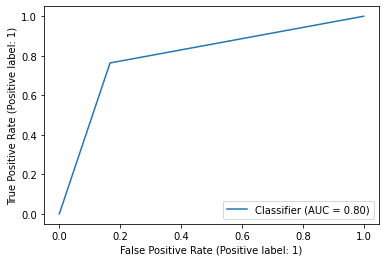

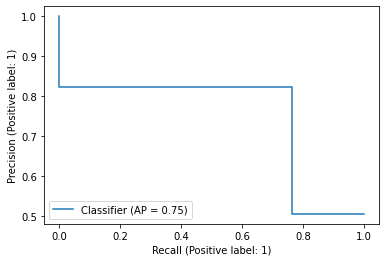

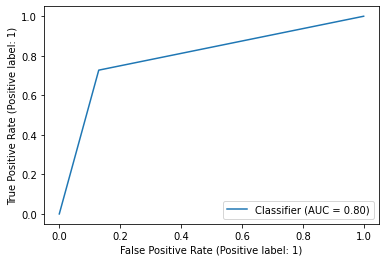

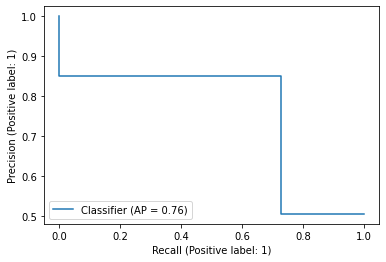

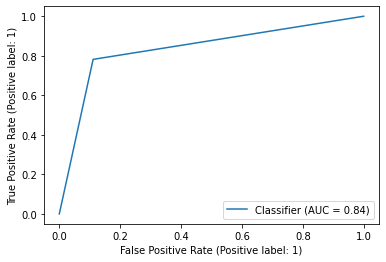

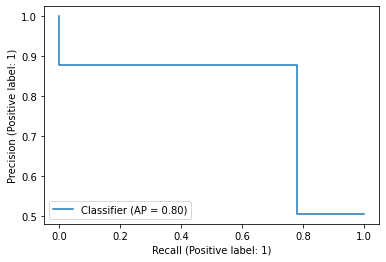

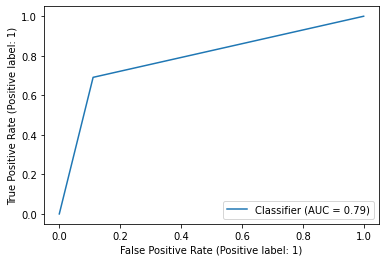

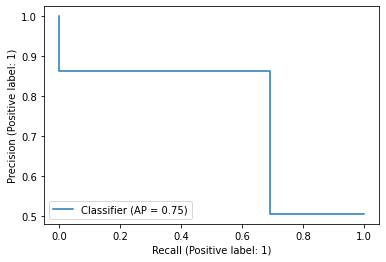

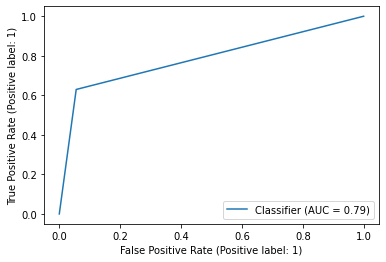

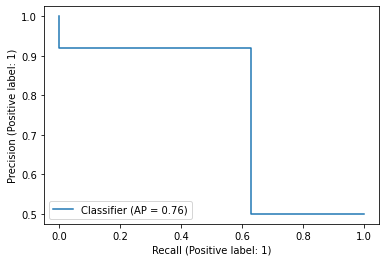

In [14]:
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
path = "./models/titanic/pyspark/"
if os.path.exists(path):
    shutil.rmtree(path, ignore_errors=True)
for clf in pyspark_classifiers:
    clf = clf.setParams(**grid[str(clf)[:str(clf).find("_")]])
    clf = clf.fit(train)
    if not os.path.exists(path):
        os.makedirs(path)
    clf.save(path+str(clf)[:str(clf).find("_")])
    real = np.array([1 if "1" in str(x) else 0 for x in clf.transform(
        test).select("label").collect()])
    pred = np.array([1 if "1" in str(x) else 0 for x in clf.transform(
        test).select("prediction").collect()])
    accuracy, confusion, roc, precision, recall = eval_methods.eval(
        clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)

clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=5)
clf.save("./models/titanic/keras.h5")
accuracy, confusion, roc, precision, recall = eval_methods.eval(
    clf, y_test, np.round(clf.predict(x_test, verbose=0))[:, 0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

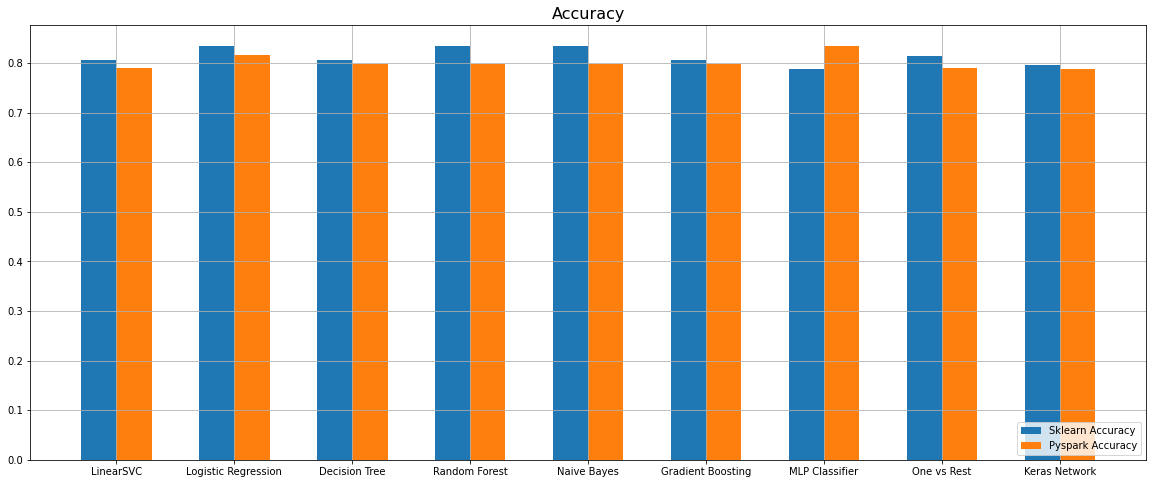

In [15]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

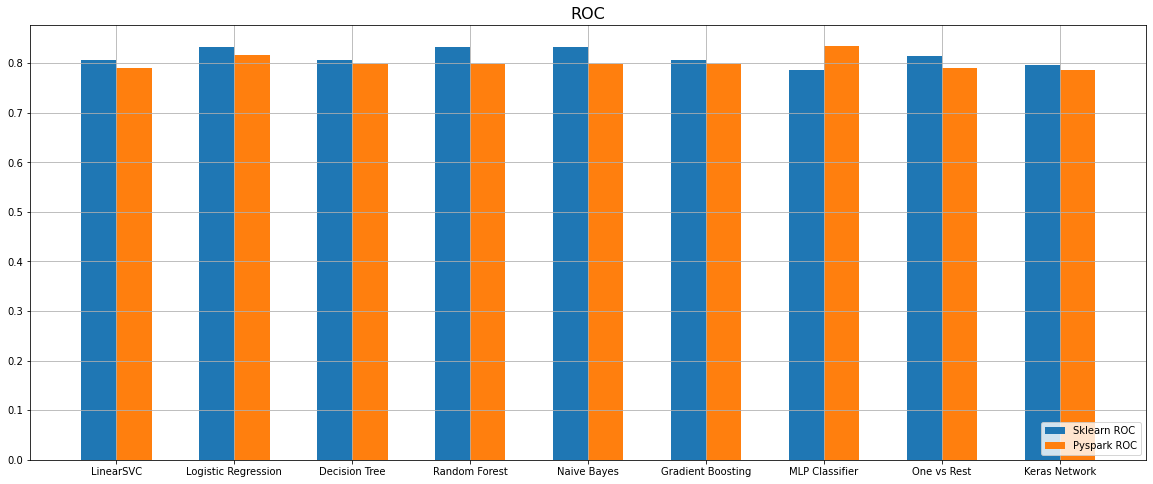

In [16]:
eval_methods.plot(sklearn_roc, pyspark_roc, "ROC")

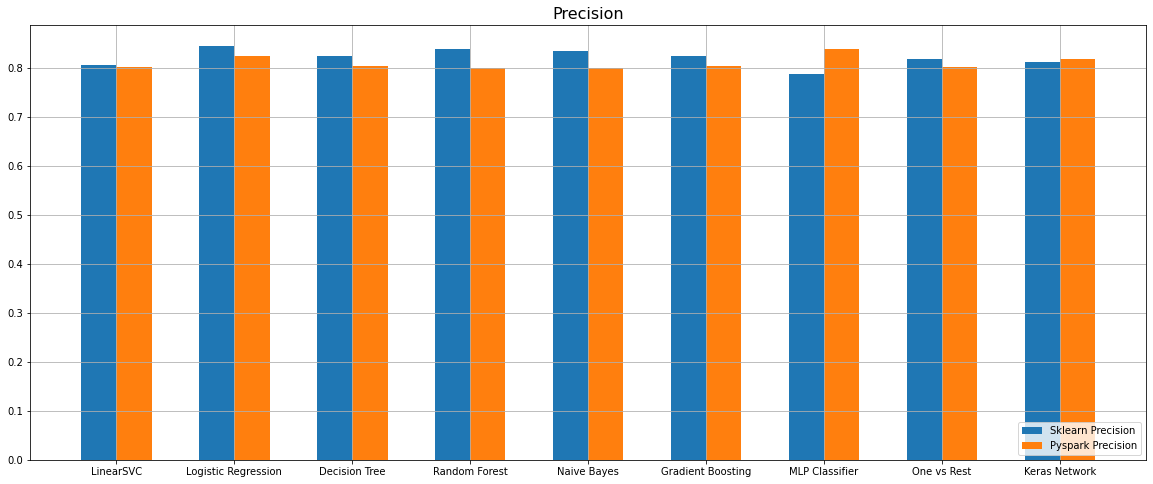

In [17]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

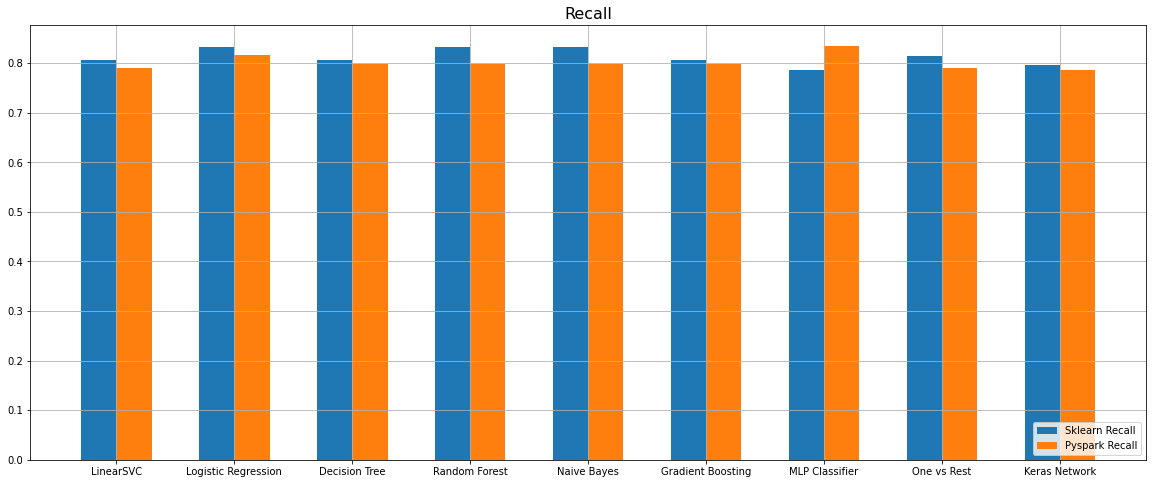

In [18]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

# Model Post-train tests

1. Model Invariant test test
2. Model Directional Expectation Tests
3. Model evaluation to ensure satisfactory perfomance

## Invariant Tests

First, we check for invariance, by keeping everything constant and changing one irrelevant feature at a time. We should not expect the survival probability to change due to the ticket number, or port of embarkation. If it runs without error then it means all the models pass this test 

In [70]:
print("Invariant Testing:\n")
for i in os.listdir("./models/titanic/sklearn/"):
    model = pickle.load(open("./models/titanic/sklearn/"+i, 'rb'))
    print(model)
    X = datasets.get_titanic().iloc[291]
    y = X["Survived"]
    X = X[1:]
    p2_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    X['Embarked'] = 2.47593535  # Change embarked
    p2_embarked_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    assert p2_prob == p2_embarked_prob
    X["Ticket"] = 1.86005416  # Change ticket number
    p2_ticket_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    assert p2_prob == p2_ticket_prob
print("Invariant testing successful")

Invariant Testing:

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features='auto',
                           random_state=0)
LogisticRegression(C=0.01, max_iter=10, random_state=0, tol=0.01)
MLPClassifier(batch_size=128, max_iter=500, random_state=0)
OneVsRestClassifier(estimator=LinearSVC(), n_jobs=1)
GaussianNB(var_smoothing=1e-07)
LinearSVC(C=0.0001, max_iter=10, random_state=0, tol=0.01)
DecisionTreeClassifier(max_depth=2, random_state=0)
RandomForestClassifier(max_depth=10, random_state=0)
Invariant testing successful


## Directional Expectation Tests

Now, we check for the relevant feature change for directional expectations. We should expect:

1. Females have a higher survival rate than males.

2. Higher class passengers have a higher survival probability than lower class passengers

3. Higher fare passengers have a higher survival probability than passengers with lower fare  

In [69]:
print("Directional Expectaiton Testing:\n")
for i in os.listdir("./models/titanic/sklearn/"):
    model = pickle.load(open("./models/titanic/sklearn/"+i, 'rb'))
    print(model)
    X = datasets.get_titanic().iloc[291]
    y = X["Survived"]
    X = X[1:]
    p2_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    X['Sex'] = 0.83739228  # Change Passanger Gender
    p2_male_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    assert p2_prob > p2_male_prob
    X["Pclass"] = 0.95828974  # Change Passanger class
    p2_class_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    assert p2_prob > p2_class_prob
    X["Fare"] = -0.575978  # Lower fare
    p2_fare_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    assert p2_prob > p2_fare_prob
print("Directional Exepction test successful")

Directional Expectaiton Testing:

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features='auto',
                           random_state=0)
LogisticRegression(C=0.01, max_iter=10, random_state=0, tol=0.01)
MLPClassifier(batch_size=128, max_iter=500, random_state=0)
OneVsRestClassifier(estimator=LinearSVC(), n_jobs=1)
GaussianNB(var_smoothing=1e-07)
LinearSVC(C=0.0001, max_iter=10, random_state=0, tol=0.01)
DecisionTreeClassifier(max_depth=2, random_state=0)
RandomForestClassifier(max_depth=10, random_state=0)
Directional Exepction test successful


## Model evaluation to ensure satisfactory perfomance

At the final step, we evaluate our models to ensure that performance does not degrade. Here we assess model performance in terms of accuracy and it should not be less than 80%.

In [30]:
from sklearn.metrics import accuracy_score

In [67]:
print("Satisfactory perfomance testing:\n")
for i in os.listdir("./models/titanic/sklearn/"):
    model = pickle.load(open("./models/titanic/sklearn/"+i, 'rb'))
    print(model)
    X = datasets.get_titanic().iloc[291]
    y = X["Survived"]
    X = X[1:]
    p2_prob = model.predict(np.array(X).reshape(1, -1))[0]  # 1.0
    # print(p2_prob)
    acc_test = accuracy_score([y], [np.round(p2_prob)])
    # print(acc_test)
    assert acc_test > 0.8, "Accuracy on the test should be > 0.80"
print("Performance testing successful")

Satisfactory perfomance testing

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features='auto',
                           random_state=0)
LogisticRegression(C=0.01, max_iter=10, random_state=0, tol=0.01)
MLPClassifier(batch_size=128, max_iter=500, random_state=0)
OneVsRestClassifier(estimator=LinearSVC(), n_jobs=1)
GaussianNB(var_smoothing=1e-07)
LinearSVC(C=0.0001, max_iter=10, random_state=0, tol=0.01)
DecisionTreeClassifier(max_depth=2, random_state=0)
RandomForestClassifier(max_depth=10, random_state=0)
Performance testing successful


===== End of the implementation =====